# homework 3: databases
by arkady shaldov, group 213

## task 1

### queries

titles released before 2018

1
```sql
SELECT title, premiered
FROM titles
WHERE premiered < 2018;

most rated titles

2
```sql
SELECT title, votes
FROM titles t
    JOIN rating r ON t.title_id = r.title_id
ORDER BY votes DESC
LIMIT 50;

most rated 2019 comedies with 7+ rating

3
```sql
SELECT title, rating, votes
FROM titles t
    JOIN rating r ON t.title_id = r.title_id
    JOIN film_genres fg ON r.title_id = fg.title_id
    JOIN genre_types gt ON fg.genre_id = gt.id
WHERE genre_name = 'Comedy' AND rating >= 7 AND premiered = 2019
ORDER BY votes DESC
LIMIT 10;

titles with Dennis Hopper and their release date

4
```sql
SELECT title, premiered
FROM titles
    JOIN crew c ON titles.title_id = c.title_id
    JOIN role_categories rc ON rc.id = c.category AND rc.role_type = 'actor'
    JOIN people p ON c.person_id = p.person_id AND p.name = 'Dennis Hopper';

noir titles count by year

5
```sql
SELECT premiered, COUNT(title) titles
FROM titles t
    JOIN film_genres fg ON t.title_id = fg.title_id
    JOIN genre_types gt ON gt.id = fg.genre_id AND gt.genre_name = 'Film-Noir'
GROUP BY premiered;

top-10 oldest actors and everyone older than 100

`EXISTS` here to check whether a person has ever performed as an actor/actress

if death year empty, considers the actor still alive (although obviously not always true, hence the results)

sorting might take a while (~2m lines), so it might be useful to add a look-ahead condition like `age > 100` to the where expression

6
```sql
SELECT name, born, died, IFNULL(died, 2022) - born age
FROM people p
WHERE EXISTS(
    SELECT *
    FROM crew c
        JOIN role_categories rc ON rc.id = c.category AND rc.role_type = 'actor' OR rc.role_type = 'actress'
    WHERE c.person_id = p.person_id
    )
ORDER BY age DESC
LIMIT 10;
```

```sql
SELECT name, born, died, IFNULL(died, 2022) - born age
FROM people p
WHERE EXISTS(
    SELECT *
    FROM crew c
        JOIN role_categories rc ON rc.id = c.category AND rc.role_type = 'actor' OR rc.role_type = 'actress'
    WHERE c.person_id = p.person_id
    )
    AND age >= 100
ORDER BY died DESC;
```

### imports

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from numpy import ones
from matplotlib.ticker import PercentFormatter

con = sqlite3.connect('imdb_small_indexed.db')
cur = con.cursor()

### comedies vs documentaries

we're working with two independent databases, each containing the list of ratings for a particular genre

In [76]:
genre_rating_query = '''
SELECT rating
FROM rating r
    JOIN film_genres fg on r.title_id = fg.title_id
    JOIN genre_types gt on fg.genre_id = gt.id
WHERE gt.genre_name = ?
ORDER BY rating DESC'''

comedies = pd.read_sql_query(genre_rating_query, con, params=['Comedy'])
documentaries = pd.read_sql_query(genre_rating_query, con, params=['Documentary'])

a histogram allows for low-effort rounding. using weight to make frequencies relative, i. e., nullify the effect of one genre being more common than other

In [77]:
def rating_hist(data):
    plt.hist(data, range=(0, 10), weights=ones(len(data)) / len(data), alpha=0.5)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plotting side by side

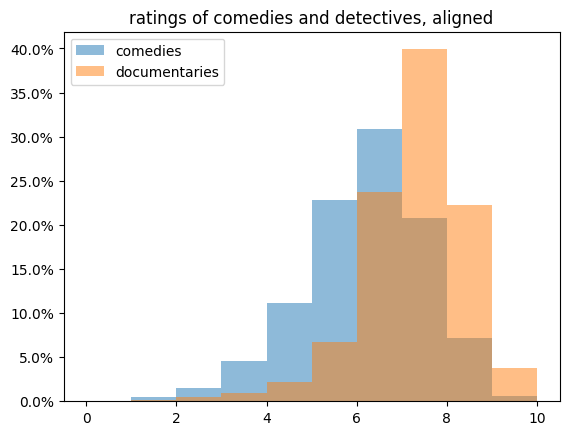

In [79]:
rating_hist(comedies)
rating_hist(documentaries)
plt.legend(('comedies', 'documentaries'))
plt.title('ratings of comedies and detectives, aligned')
plt.show()

critics seem to prefer documentaries

### long-livers

creating two independent tables seem superior to having a single one
1. retrieving top longlivers is faster since no need to walk through the whole over-100 table
2. probably less space since just a single row for each
3. adding new actors to top longlivers is much simpler

a query for writing the top-10 long-living actors query, cf. above, into a separate table

In [83]:
create_top_longlivers_query = '''
CREATE TABLE top_longlivers
AS SELECT name, born, died, IFNULL(died, 2022) - born age
FROM people p
WHERE EXISTS(
    SELECT *
    FROM crew c
        JOIN role_categories rc ON rc.id = c.category AND rc.role_type = 'actor' OR rc.role_type = 'actress'
    WHERE c.person_id = p.person_id
    ) AND age > 100
ORDER BY age DESC
LIMIT 10;
'''

In [86]:
cur.execute(create_top_longlivers_query)

here it is

In [87]:
pd.read_sql_query('SELECT * FROM top_longlivers', con)

,name,born,died,age
0,Paul Walsh,21,None,2001
1,Koray Gelisen,1067,None,955
2,William S. Hooser,1836,None,186
3,Vilmos Radó,1847,None,175
4,California Truman,1849,None,173
5,Louis Hahn,1850,None,172
6,André Sylvane,1850,None,172
7,Charles Dungan,1853,None,169
8,Edmond Duquesne,1854,None,168
9,Maurice Ordonneau,1854,None,168


analogously, a query for writing all actors over 100 into a table

In [88]:
create_over_100_query = '''
CREATE TABLE over_100
AS SELECT name, born, died, IFNULL(died, 2022) - born age
FROM people p
WHERE EXISTS(
    SELECT *
    FROM crew c
        JOIN role_categories rc ON rc.id = c.category AND rc.role_type = 'actor' OR rc.role_type = 'actress'
    WHERE c.person_id = p.person_id
    )
    AND age >= 100
ORDER BY died DESC;
'''

In [89]:
cur.execute(create_over_100_query)

here it is too

In [90]:
pd.read_sql_query('SELECT * FROM over_100', con)

,name,born,died,age
0,Olivia de Havilland,1916,2020.0,104
1,Kirk Douglas,1916,2020.0,104
2,Baby Peggy,1918,2020.0,102
3,Else Blangsted,1920,2020.0,100
4,Roger Borniche,1919,2020.0,101
...,...,...,...,...
3790,Csaba Skultéty,1920,NaN,102
3791,Olympio Guilherme,1902,NaN,120
3792,Oldrich Jezek,1909,NaN,113
3793,Szokol Aoles,1899,NaN,123


## task 2

a query for an average ratio of female cast in a title, per year, per genre

the first select retrieves every title and the ratio of female cast in it. the second one groups the movies by year and genre and counts the average

movies where no cast or no release date is given are excluded

In [2]:
female_query = '''
SELECT premiered, genre_name, AVG(fem_perc) female_percentage
FROM (
    SELECT title, premiered, genre_name, SUM(CASE WHEN rc.role_type = 'actress' THEN 1.0 ELSE 0 END) / SUM(CASE WHEN rc.role_type = 'actress' or rc.role_type = 'actor' THEN 1 ELSE 0 END) fem_perc
    FROM titles t
        JOIN crew c ON t.title_id = c.title_id
        JOIN role_categories rc ON c.category = rc.id
        JOIN film_genres fg ON t.title_id = fg.title_id
        JOIN genre_types gt ON fg.genre_id = gt.id
    WHERE premiered is not null
    GROUP BY title, genre_name
)
WHERE fem_perc is not null
GROUP BY premiered, genre_name
ORDER BY premiered DESC;
'''

In [3]:
fem_df = pd.read_sql_query(female_query, con)

the results

In [4]:
fem_df

,premiered,genre_name,female_percentage
0,2028,Action,0.444444
1,2028,Adventure,0.444444
2,2028,Drama,0.444444
3,2027,Adventure,0.000000
4,2027,Drama,0.000000
...,...,...,...
2827,1903,Drama,0.333333
2828,1902,Drama,1.000000
2829,1900,Biography,0.166667
2830,1900,Drama,0.166667


barely informative because of the NaNs, requiring us to plot

In [5]:
fem_df.pivot_table(values='female_percentage', index='premiered', columns='genre_name').sort_values(by='premiered', ascending=False)

genre_name,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
premiered,,,,,,,,,,,,,,,,,,,,,
2028,0.444444,NaN,0.444444,NaN,NaN,NaN,NaN,NaN,0.444444,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026,0.750000,NaN,0.750000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,NaN,NaN,0.500000,NaN,0.500000,NaN,NaN,NaN,0.666667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024,0.463333,NaN,0.625000,NaN,NaN,0.500000,NaN,NaN,0.214286,NaN,...,NaN,NaN,0.571429,NaN,NaN,NaN,NaN,0.5,NaN,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,NaN,NaN,NaN,NaN,0.500000,0.666667,0.5,NaN,0.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,0.333333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


relative female cast per year, ignoring genres. there is an increase, though the tendence seems insignificant

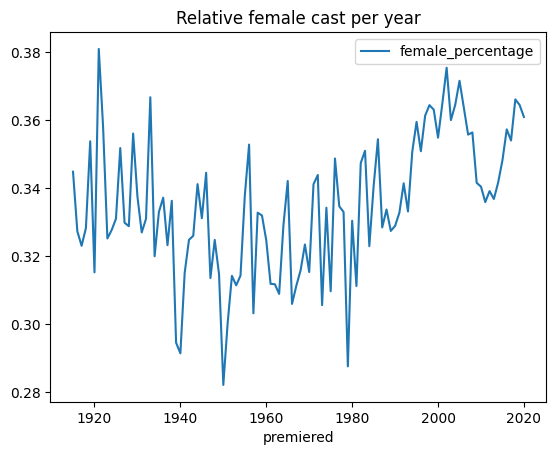

In [26]:
fem_df[fem_df['premiered'].between(1915, 2020)].pivot_table(values='female_percentage', index='premiered').sort_values(by='premiered', ascending=False).plot(title='Relative female cast per year')
plt.show()

the stats per genre are much more fun. an obvious high for adult movies, as well as romance movies and musicals. more surprising might be the extreme low for documentaries

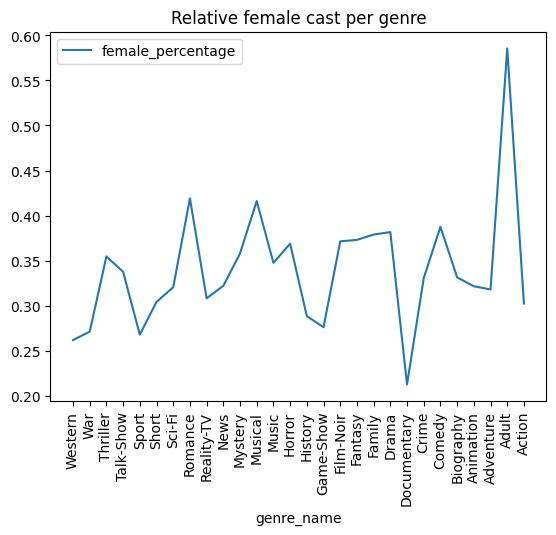

In [28]:
genre_pivot = fem_df.pivot_table(values='female_percentage', index='genre_name').sort_values(by='genre_name', ascending=False)
genre_pivot.plot(title='Relative female cast per genre')
plt.xticks(range(0, len(genre_pivot.index)), genre_pivot.index, rotation=90)
plt.show()

### plots per genre

let's look at particular genres. the plots are cropped where the stats don't look representing

adult movies are becoming more female over time, for a reason (i'm no expert)

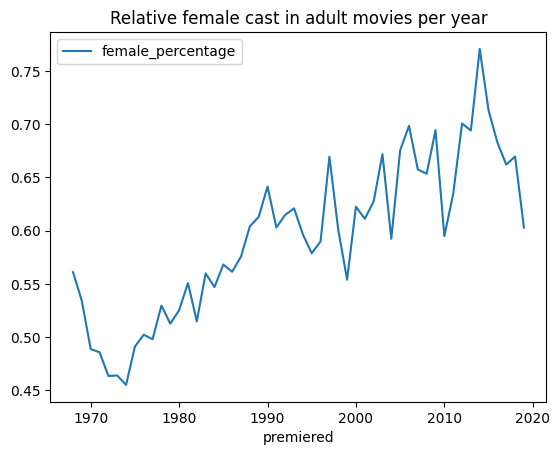

In [72]:
fem_df[fem_df['premiered'].between(1966, 2019) & (fem_df['genre_name'] == 'Adult')].pivot_table(values='female_percentage', index='premiered').sort_values(by='premiered', ascending=False).plot(title='Relative female cast in adult movies per year')
plt.show()

happier news, there are more women in the game show industry too

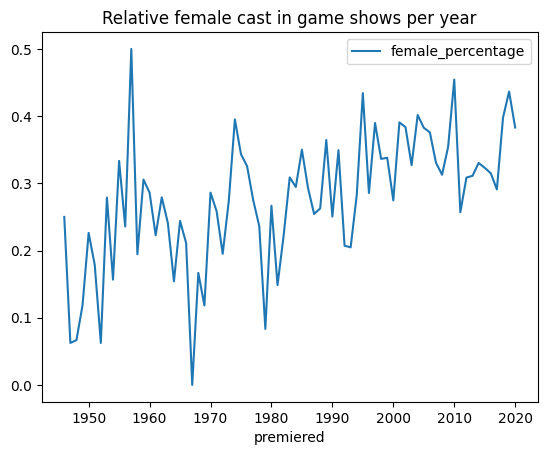

In [96]:
fem_df[fem_df['premiered'].between(1945, 2020) & (fem_df['genre_name'] == 'Game-Show')].pivot_table(values='female_percentage', index='premiered').sort_values(by='premiered', ascending=False).plot(title='Relative female cast in game shows per year')
plt.show()

documentaries are also seeing a significant increase

<AxesSubplot: title={'center': 'Relative female cast in documentaries per year'}, xlabel='premiered'>

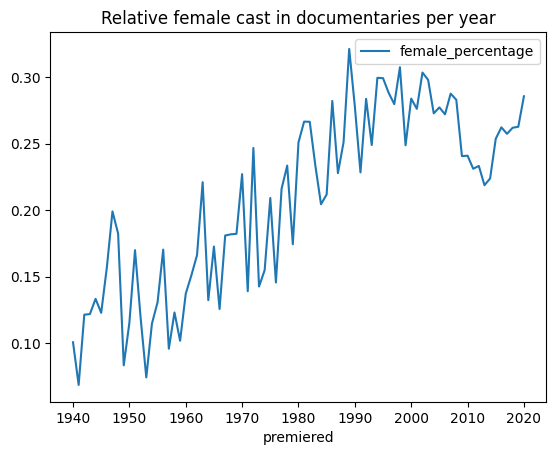

In [105]:
fem_df[fem_df['premiered'].between(1940, 2020) & (fem_df['genre_name'] == 'Documentary')].pivot_table(values='female_percentage', index='premiered').sort_values(by='premiered', ascending=False).plot(title='Relative female cast in documentaries per year')

comedies (and there are **a lot** of comedies out there) are much more stable, on the contrary, with even a slight decrease

<AxesSubplot: title={'center': 'Relative female cast in comedies per year'}, xlabel='premiered'>

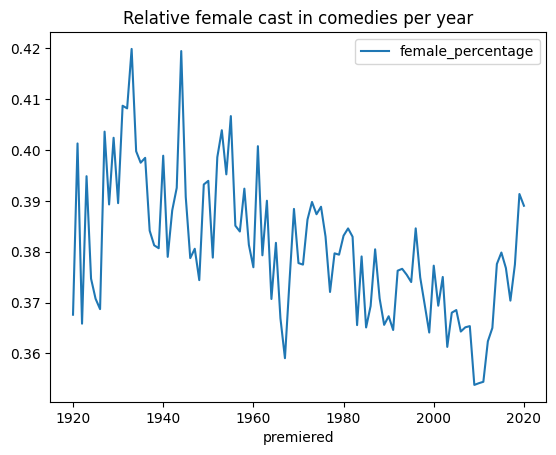

In [107]:
fem_df[fem_df['premiered'].between(1920, 2020) & (fem_df['genre_name'] == 'Comedy')].pivot_table(values='female_percentage', index='premiered').sort_values(by='premiered', ascending=False).plot(title='Relative female cast in comedies per year')

## task 3

a simple extension of the given database with support for user accounts and user ratings.

there are two objects we're dealing with, users and user ratings. the first one contains the list of user accounts, with their profile info. the second one is a list with title-user primary key (both values are taken from corresponding tables), which contains the scores the users have given to the movies, and comments, if any.

it might be useful to index the `title_id` and `user_id` columns of user ratings to simplify retrieving all user reviews of a title and all reviews left by a user

except for the data for the two tables, there is no lack of any required data in the database

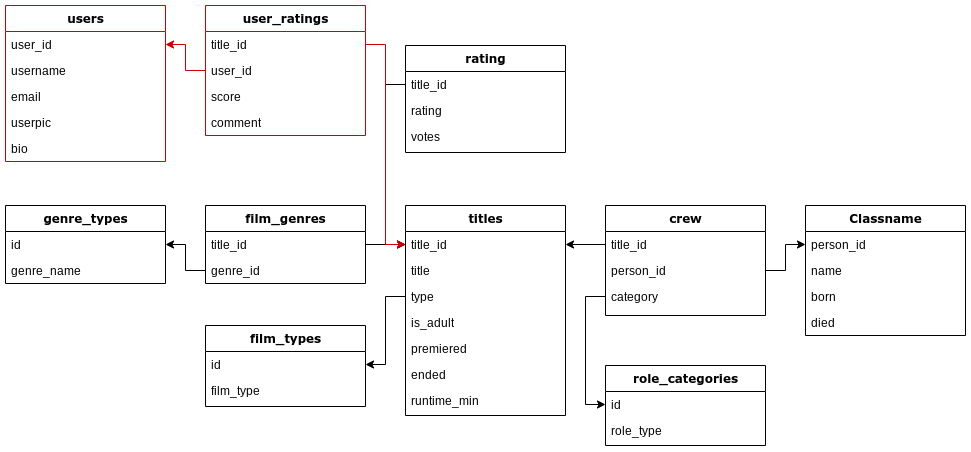